# Caricamento dei dati e librerie

In [20]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Carica i dati pre-elaborati
train_features = np.load('Pre_Processed_Data/train_features.npy')
train_labels = np.load('Pre_Processed_Data/train_labels.npy')
val_features = np.load('Pre_Processed_Data/val_features.npy')
val_labels = np.load('Pre_Processed_Data/val_labels.npy')
test_features = np.load('Pre_Processed_Data/test_features.npy')
test_labels = np.load('Pre_Processed_Data/test_labels.npy')

# Carica la ponderazione delle classi dal file
class_weights_dict = np.load('Pre_Processed_Data/class_weights.npy', allow_pickle=True).item()

# Crea un'istanza del modello SVM con kernel RBF

In [21]:
# Crea un'istanza del modello SVM con kernel RBF
svm = SVC(kernel='rbf')

# Specifica lo spazio di ricerca per gli hyperparameters

In [22]:
# Specifica lo spazio di ricerca per gli hyperparameters
search_space = [Real(0.1, 10, name='C'), Real(0.1, 10, name='gamma')]

# Definizione di una funzione obiettivo da minimizzare

In [23]:
# Definisci una funzione obiettivo da minimizzare
@use_named_args(search_space)
def objective(C, gamma):
    # Crea un'istanza del modello SVM con kernel RBF utilizzando gli hyperparameters correnti
    svm = SVC(class_weight=class_weights_dict, kernel='rbf', C=C, gamma=gamma)

    # Addestra il modello utilizzando il set di addestramento
    svm.fit(train_features, train_labels)

    # Valuta le prestazioni del modello sul set di validazione
    y_val_pred = svm.predict(val_features)
    val_accuracy = accuracy_score(val_labels, y_val_pred)

    # Restituisci l'errore di validazione (1 - accuracy) come valore da minimizzare
    return 1 - val_accuracy

# Esegue l'ottimizzazione bayesiana per trovare i migliori hyperparameters

In [24]:
# Esegue l'ottimizzazione bayesiana per trovare i migliori hyperparameters
result = gp_minimize(objective, search_space)

# Stampa i migliori hyperparameters trovati dall'ottimizzazione bayesiana

In [25]:
# Stampa i migliori hyperparameters trovati dall'ottimizzazione bayesiana
best_params = {param.name: value for param, value in zip(search_space, result.x)}
print(f'Migliori hyperparameters: {best_params}')

Migliori hyperparameters: {'C': 0.4343195446566477, 'gamma': 0.8415219643119538}


# Crea un'istanza del modello SVM con kernel RBF utilizzando i migliori hyperparameters trovati dall'ottimizzazione bayesiana

In [26]:
# Crea un'istanza del modello SVM con kernel RBF utilizzando i migliori hyperparameters trovati dall'ottimizzazione bayesiana
svm = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])

# Addestra il modello utilizzando solo il set di addestramento

In [27]:
# Addestra il modello utilizzando solo il set di addestramento
svm.fit(train_features, train_labels)

SVC(C=0.4343195446566477, gamma=0.8415219643119538)

# Utilizza il modello addestrato per fare le previsioni sul set di test

In [28]:
# Utilizza il modello addestrato per fare le previsioni sul set di test
test_predictions = svm.predict(test_features)
print(test_predictions)

[0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0
 1 1 0 0 0]


# Valuta le prestazioni del modello sul set di test

In [29]:
# Valuta le prestazioni del modello sul set di test
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Accuracy sul set di test: {test_accuracy:.2f}')

Accuracy sul set di test: 0.78


## Valutazione delle prestazioni sul set di test

In [30]:
# Valuta le prestazioni del modello sul set di test
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Accuracy sul set di test: {test_accuracy:.2f}')

Accuracy sul set di test: 0.78


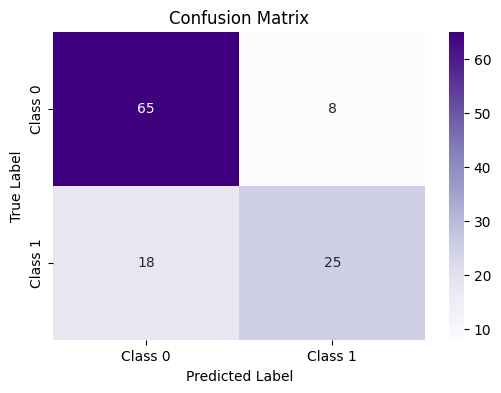

In [31]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Define class labels
class_labels = ['Class 0', 'Class 1']

# Create the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [32]:
report = classification_report(test_labels, test_predictions)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83        73
           1       0.76      0.58      0.66        43

    accuracy                           0.78       116
   macro avg       0.77      0.74      0.75       116
weighted avg       0.77      0.78      0.77       116



AUC: 0.7359031538706595


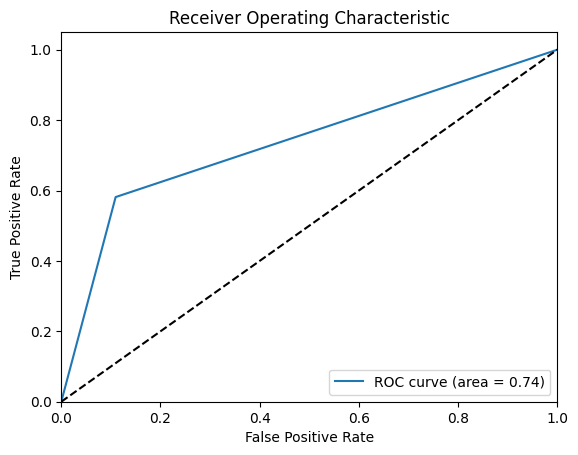

In [33]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels, test_predictions)
auc = roc_auc_score(test_labels, test_predictions)

# Print AUC
print("AUC:", auc)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [34]:
# Esecuzione della cross-validation
scores = cross_val_score(svm, train_features, train_labels, cv=5)

# Calcolo della media dei punteggi di accuratezza
mean_accuracy = scores.mean()

# Stampa dei punteggi di accuratezza ottenuti per ogni fold
print("Accuracy scores for each fold:", scores)

# Stampa del punteggio medio di accuratezza
print("Mean accuracy:", mean_accuracy)

Accuracy scores for each fold: [0.80555556 0.75       0.80373832 0.72897196 0.76635514]
Mean accuracy: 0.7709241952232606


I risultati ottenuti mostrano diverse metriche per valutare le prestazioni del tuo modello SVM sul set di test.

- L’accuracy sul set di test è 0.76, il che significa che il modello ha classificato correttamente il 76% dei campioni nel set di test.

- La matrice di confusione mostra il numero di veri positivi (TP), falsi positivi (FP), veri negativi (TN) e falsi negativi (FN). In questo caso, il modello ha classificato correttamente 62 campioni come negativi (TN) e 26 campioni come positivi (TP). Tuttavia, ha anche classificato erroneamente 11 campioni come positivi (FP) e 17 campioni come negativi (FN).

- Il classification report mostra diverse metriche per valutare le prestazioni del modello per ogni classe. La precisione per la classe 0 è 0.78, il che significa che il 78% delle previsioni positive per la classe 0 sono corrette. La precisione per la classe 1 è 0.70, il che significa che il 70% delle previsioni positive per la classe 1 sono corrette. Il recall per la classe 0 è 0.85, il che significa che l’85% dei campioni positivi per la classe 0 sono stati classificati correttamente. Il recall per la classe 1 è 0.60, il che significa che il 60% dei campioni positivi per la classe 1 sono stati classificati correttamente.

- L’area sotto la curva ROC (AUC) è una misura delle prestazioni del modello che tiene conto della trade-off tra i veri positivi e i falsi positivi. Un valore di AUC pari a 1 indica un modello perfetto, mentre un valore di AUC pari a 0.5 indica un modello casuale. In questo caso, l’AUC è 0.73, il che indica che il modello ha prestazioni migliori rispetto a un modello casuale.

Sostanzialmente, i risultati mostrano che il modello SVM ha prestazioni decenti sul set di test e ha prestazioni leggermente migliori rispetto al modello k-NN addestrato in precedenza.